In [1]:
import torch
import matplotlib.pyplot as plt
from matplotlib import patches
from collections import Counter
from torch import nn, optim
from config import config
from net import load_model
from Dataset.utils import *
from train import train

In [2]:
model, cfg = load_model(config, num_classes=15, path='model/weights/model_40_epochs.pt', freeze=True)

In [3]:
def predict(image_path, model):
    split = image_path.split('/')
    fname = split[-1]
    path = '/'.join(split[:-1])
    ds = OktoberfestDataset([fname], path, inference=True)
    img, orig = ds[0]
    img = img.unsqueeze(0)
    model.eval()
    out = model(img)
    return orig, out

In [16]:
image, out = predict('../../data/test/1526742310765_20.jpg', model)

In [17]:
def remove_extra_boxes(boxes, classes):
    good_boxes, good_classes = [], []
    for box, c in zip(boxes, classes):
        if not_repeat(box, good_boxes):
            good_boxes.append(box), good_classes.append(c)
    return torch.stack(good_boxes), torch.stack(good_classes)
        
def not_repeat(box, boxes):
    for b in boxes:
        if iou_pytorch(box, b) > .7:
            return False
    return True
        
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs_area = (outputs[2] - outputs[0]) * (outputs[3] - outputs[1])
    labels_area = (labels[2] - labels[0]) * (labels[3] - labels[1])
    
    # get area of intersection
    mins = torch.maximum(outputs[:2], labels[:2])
    maxs = torch.minimum(outputs[2:], labels[2:])
    intersection = (maxs[0] - mins[0]) * (maxs[1] - mins[1])
    union = outputs_area + labels_area - intersection
    return intersection / union

good_boxes = out[0]['instances']._fields['scores'] > .4
pred_boxes = out[0]['instances']._fields['pred_boxes'].tensor[good_boxes].cpu()#.numpy()
pred_classes = out[0]['instances']._fields['pred_classes'][good_boxes].cpu()

Without removing high IOU objects, this is the output.

In [29]:
classes_dict = {
    0: 'Bier',
    1: 'Bier Mass',
    2: 'Weissbier',
    3: 'Cola',
    4: 'Weissbier',
    5: 'Curry-Wurst',
    6: 'Weisswein',
    7: 'A-Schorle',
    8: 'Jaegermeister',
    9: 'Pommes',
    10: 'Burger',
    11: 'Williamsbirne',
    12: 'Alm-Breze',
    13: 'Brotzeitkorb',
    14: 'Kaesespaetzle'
}

Bier Mass        red
Bier Mass        blue
Williamsbirne    green
Williamsbirne    yellow
Williamsbirne    red
Williamsbirne    black


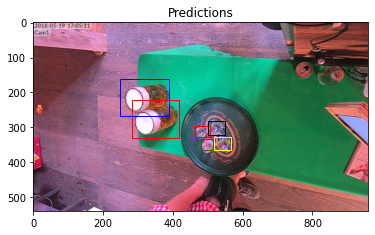

In [37]:
fig, ax = plt.subplots()
ax.imshow(image)
colors = ['red', 'blue', 'green', 'yellow', 'red', 'black']
for box, c, color in zip(pred_boxes, pred_classes, colors):
    print(f'{classes_dict[int(c)]:<16} {color}')
    patch = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], edgecolor=color, facecolor='none')
    ax.add_patch(patch)
ax.set_title('Predictions')
plt.show()

Here are the actual bboxes

Williamsbirne    red
Williamsbirne    blue
Williamsbirne    green
Williamsbirne    yellow
Bier Mass        red
Bier Mass        black


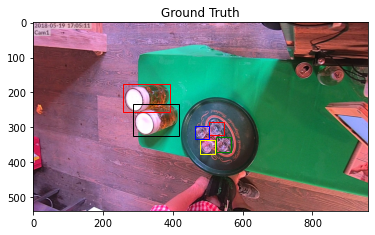

In [36]:
row = '1526742310765_20.jpg 6 11 1008 570 86 74 11 924 590 85 80 11 1045 658 89 82 11 956 672 84 80 1 516 350 265 164 1 568 468 269 182'
row = row.split()
num = int(row[1])
fig, ax = plt.subplots()
ax.imshow(image)
colors = ['red', 'blue', 'green', 'yellow', 'red', 'black']
boxes = [[float(n) for n in row[i+1:i+5]] for i in range(2, 2+5*num, 5)]
classes = [int(row[i]) for i in range(2, 2+5*num, 5)]
for box,c, color in zip(boxes, classes, colors):
    print(f'{classes_dict[c]:<16} {color}')
    box[2] += box[0]
    box[3] += box[1]
    for i in range(4):
        box[i] = box[i] // 2
    patch = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], edgecolor=color, facecolor='none')
    ax.add_patch(patch)
ax.set_title('Ground Truth')
plt.show()

In [9]:
boxes

array([[368.46695, 239.83113, 483.15817, 310.94168],
       [452.36667, 263.2777 , 564.83813, 343.36945],
       [456.89587, 256.29926, 560.9713 , 336.19598]], dtype=float32)

In [15]:
out

[{'instances': Instances(num_instances=100, image_height=540, image_width=960, fields=[pred_boxes = Boxes(tensor([[368.4669, 239.8311, 483.1582, 310.9417],
          [452.3667, 263.2777, 564.8381, 343.3694],
          [456.8959, 256.2993, 560.9713, 336.1960],
          [461.8922, 266.9673, 549.5483, 339.7718],
          [460.6748, 254.0917, 572.8637, 337.6379],
          [456.8959, 256.2993, 560.9713, 336.1960],
          [452.3667, 263.2777, 564.8381, 343.3694],
          [-21.2432,  -2.7227,  -6.6550,   2.2560],
          [461.8922, 266.9673, 549.5483, 339.7718],
          [367.5349, 239.0306, 484.2007, 307.0820],
          [464.3756, 258.2215, 561.5756, 334.0497],
          [-21.2432,  -2.7227,  -6.6550,   2.2560],
          [-21.2432,  -2.7227,  -6.6550,   2.2560],
          [-21.2432,  -2.7227,  -6.6550,   2.2560],
          [-21.2432,  -2.7227,  -6.6550,   2.2560],
          [966.3400, 532.6819, 981.3400, 547.2865],
          [-21.2432,  -2.7227,  -6.6550,   2.2560],
          [9